# Summary
## Objective: Improve baseline performance by injecting more regularization

## Findings: High regularization improved baseline performance

## Model Details
* Backbone: MobileNetV3-Large (alpha=1.0, extract output from layer 142)
* Output Regularization: L1 (1E-1)
* Spatial Dropout: 15%, Regular Dropout = 15%
* Total params: 203,289
* Trainable params: 197,193
* Non-trainable params: 6,096
* Batch Size: 4
* Training Epochs: 25

## Preprocessing Details
* Dataset: EyePACS-AIROGS-light
* Image Dimension: 256x256
* HFLIP: True
* VFLIP: True
* Rotation: False
* Brightness: True (+/- 5%)
* Noise Variance: 10.0

## Best Model by Val Loss: Evaluation Metrics on Test Set
* loss: 0.2676
* binary_accuracy: 0.9210
* auc: 0.9732
* precision: 0.9136
* recall: 0.9300

## Epoch 25 Model: Evaluation Metrics on Test Set
* loss: 0.2776
* binary_accuracy: 0.9240
* auc: 0.9704
* precision: 0.9344
* recall: 0.9120

# Imports

In [4]:
import pandas as pd
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from keras.layers import SpatialDropout2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Concatenate, ReLU, AveragePooling2D, UpSampling2D
from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, MobileNetV2, EfficientNetB3, Xception, VGG19, InceptionV3, EfficientNetB0, EfficientNetB2, Xception
from tensorflow.keras import regularizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
import keras
import numpy as np
import random
import shutil

# Create a custom function that injects random noise into the image. Create unique generators using seeds and combine

In [2]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
target = 256

# inject noise but keep dark parts black
def addNoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

    randStd = random.uniform(0, 10.0) # 15
    gaussian = np.random.normal(randStd*-1, randStd, (target, target,3))
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    image[mask == 0] = [0,0,0]
    image = preprocess_input(image)
    return image

dataPath = '/kaggle/input/eyepacs-airogs-light/release-crop/release-crop/'

# combine two unique generators using noise injection
batchSize = 4
trainDataGen = ImageDataGenerator(preprocessing_function=addNoise, horizontal_flip=True,vertical_flip=True,rotation_range=0,brightness_range=(0.95, 1.05))
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=1)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Model Architecture

In [5]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPool2D

# simple model that uses mobilenet background
def getModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    
    transfer = keras.applications.MobileNetV3Large(
        weights='imagenet', include_top=False, input_tensor=model_input
    )
    x = transfer.get_layer(index=142).output
    
    x = SpatialDropout2D(0.15)(x)
    x = Conv2D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.15)(x)

    model_output = Dense(1, activation='sigmoid') (x)

    return keras.Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5) # factor=0.85
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='val-best.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                              

# Model Training

In [6]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(trainGen, steps_per_epoch = len(trainGen1)*2,validation_data=valGen, validation_steps=len(valGen), epochs=25, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/25


2023-09-03 13:44:21.115825: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2500/2500 [==============================] - 198s 69ms/step - loss: 41.9120 - binary_accuracy: 0.5780 - auc: 0.5974 - precision: 0.5796 - recall: 0.5682 - val_loss: 26.1778 - val_binary_accuracy: 0.7667 - val_auc: 0.8325 - val_precision: 0.7628 - val_recall: 0.7741 - lr: 1.0000e-04
Epoch 2/25
2500/2500 [==============================] - 152s 61ms/step - loss: 18.8908 - binary_accuracy: 0.6958 - auc: 0.7511 - precision: 0.6954 - recall: 0.6968 - val_loss: 11.4118 - val_binary_accuracy: 0.7815 - val_auc: 0.8921 - val_precision: 0.7111 - val_recall: 0.9481 - lr: 1.0000e-04
Epoch 3/25
2500/2500 [==============================] - 151s 60ms/step - loss: 7.1806 - binary_accuracy: 0.7658 - auc: 0.8371 - precision: 0.7691 - recall: 0.7596 - val_loss: 3.4651 - val_binary_accuracy: 0.8463 - val_auc: 0.9270 - val_precision: 0.8667 - val_recall: 0.8185 - lr: 1.0000e-04
Epoch 4/25
2500/2500 [==============================] - 153s 61ms/step - loss: 1.9241 - binary_accuracy: 0.8144 - auc: 0.8865 - pre

# Model Evaluation

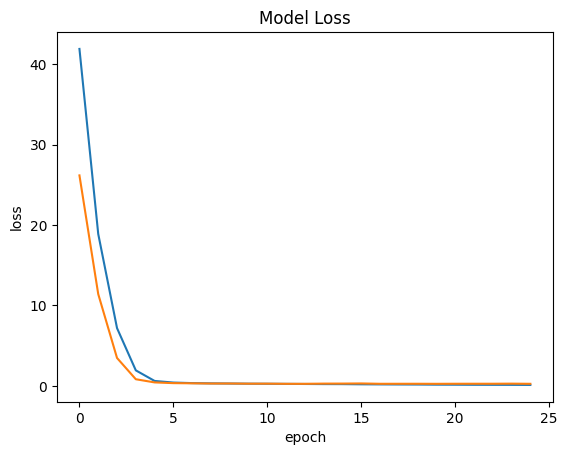

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

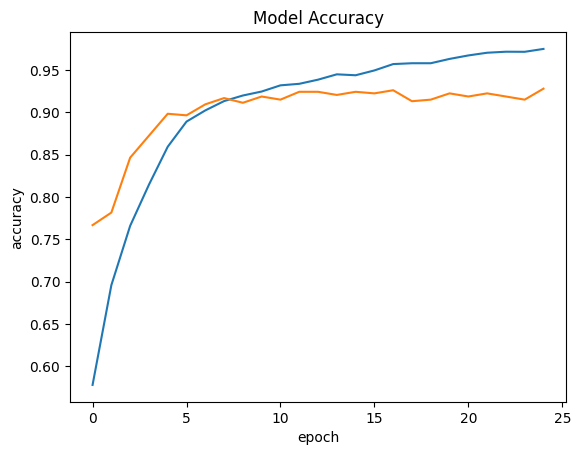

In [8]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [9]:
model.evaluate(testGen)

1000/1000 [==============================] - 11s 11ms/step - loss: 0.2776 - binary_accuracy: 0.9240 - auc: 0.9704 - precision: 0.9344 - recall: 0.9120


[0.2775702178478241,
 0.9240000247955322,
 0.9703560471534729,
 0.9344262480735779,
 0.9120000004768372]

In [10]:
model.load_weights('/kaggle/working/val-best.h5')

In [11]:
model.evaluate(testGen)

1000/1000 [==============================] - 9s 9ms/step - loss: 0.2676 - binary_accuracy: 0.9210 - auc: 0.9732 - precision: 0.9136 - recall: 0.9300


[0.26759618520736694,
 0.9210000038146973,
 0.9732080698013306,
 0.9135559797286987,
 0.9300000071525574]